# Data Analyst Nanodegree
## Project 5: Intro. to Machine Learning: Enron POI Identifier 

## By Stephen Fox
## February 2017
_____

### Overview

This notebook contains data exploratory and coding components of the project. For discussion and analysis, please refer to the accompanying report.

In [1]:
#!/usr/bin/python

# Import libraries

import sys
import pickle
import numpy as np
import pandas as pd

%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

#sys.path.append("../tools/")

# Import data formating functions from other files

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the dictionary containing the dataset

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

I'll take a high level look at the size and basic structure of the data dictionary:

In [3]:
print "Gross data set size (# people):", len(data_dict)
print '\n'
print "example per person (Using Jeffrey Skilling):"
print data_dict["SKILLING JEFFREY K"]
print '\n'

# Substract 1 to account for the 'poi' field, which is a label
print "features per person:", len(data_dict["SKILLING JEFFREY K"])-1

Gross data set size (# people): 146


example per person (Using Jeffrey Skilling):
{'salary': 1111258, 'to_messages': 3627, 'deferral_payments': 'NaN', 'total_payments': 8682716, 'exercised_stock_options': 19250000, 'bonus': 5600000, 'restricted_stock': 6843672, 'shared_receipt_with_poi': 2042, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 26093672, 'expenses': 29336, 'loan_advances': 'NaN', 'from_messages': 108, 'other': 22122, 'from_this_person_to_poi': 30, 'poi': True, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 1920000, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88}


features per person: 20


So the gross data dictionary contains 146 unique samples (presumably unique people). For each person, we confirm that there are 20 features (excluding 'poi'). This result is consistent with the feature list provided.

In [4]:
# Convert data dictionary into a pandas dataframe, for ease of EDA

df = pd.DataFrame.from_records(list(data_dict.values()))
employees = pd.Series(list(data_dict.keys()))
df.set_index(employees, inplace = True)

A cursory glance at the data reveals that there is a large number of 'NaN' values for the various features. For example, consider the 'bonus' field:

In [5]:
df['bonus'].value_counts()

NaN         64
600000       6
1000000      6
700000       5
400000       4
800000       4
750000       4
325000       3
850000       3
200000       3
300000       3
900000       2
1200000      2
100000       2
1500000      2
3000000      2
1100000      2
500000       2
250000       2
2000000      2
350000       2
5249999      1
97343619     1
2600000      1
1700000      1
450000       1
5600000      1
8000000      1
788750       1
7000000      1
509870       1
1150000      1
1250000      1
70000        1
4175000      1
650000       1
1350000      1
3100000      1
1300000      1
425000       1
1750000      1
2500000      1
Name: bonus, dtype: int64

A large number (64) of the 146 samples do not include bonus data. There are three options to deal with this issue: 

First, I could ignore this fact and move ahead with the analysis. However, unless the proportion of NaNs between POIs and non-POIs is identical, this runs the risk of biasing the machine learning algorithm to use the presence or absence of NaN as a predictive indicator. 

Second, I can replace the 'NaN' strings with np.nan. This is the approach I will use during the machine learning portion later in the project, since it lets me use only those data points where an actual value exists, for a given feature. However, for the exploratory phase and outlier detection phase of the project, using np.nan is not desirable, since it will inhibit my ability to e.g. sum various features to check for data consistency (i.e. number + np.nan = np.nan). 

Third, I could convert NaN values to zero. I believe this is undesirable for the machine learning phase of the project, since doing so would make it hard to distinguish between a person with a very low value for a given field and someone with a NaN value, since in both cases the value would be at or near zero. However, for the data exploratory and outlier detection phase, I believe this is a good approach, since it will let me sum features across columns to conduct data checks of various types.

To summarize, I will replace 'NaN' values with zero now and then use np.nan during the machine learning portion of the project.

In [6]:
df.replace('NaN', 0, inplace = True)

After running np.nan, the NaN values are no longer counted as part of a given field, as is desired, having been replaced by zeroes instead. For example, consider 'bonus' again:

In [8]:
df['bonus'].value_counts()

0           64
1000000      6
600000       6
700000       5
400000       4
750000       4
800000       4
850000       3
300000       3
200000       3
325000       3
500000       2
1500000      2
100000       2
1200000      2
250000       2
900000       2
3000000      2
2000000      2
1100000      2
350000       2
1150000      1
70000        1
1300000      1
650000       1
788750       1
425000       1
3100000      1
450000       1
1750000      1
2600000      1
8000000      1
2500000      1
1350000      1
97343619     1
4175000      1
1700000      1
509870       1
7000000      1
5249999      1
1250000      1
5600000      1
Name: bonus, dtype: int64

In [9]:
# Confirm that the various fields are the desired data type

df.dtypes

bonus                         int64
deferral_payments             int64
deferred_income               int64
director_fees                 int64
email_address                object
exercised_stock_options       int64
expenses                      int64
from_messages                 int64
from_poi_to_this_person       int64
from_this_person_to_poi       int64
loan_advances                 int64
long_term_incentive           int64
other                         int64
poi                            bool
restricted_stock              int64
restricted_stock_deferred     int64
salary                        int64
shared_receipt_with_poi       int64
to_messages                   int64
total_payments                int64
total_stock_value             int64
dtype: object

The label ('poi') is a boolean (0 = not a POI; 1 = POI). All the features are integer values, with the exception of email addresses. This is the expected behavior.

In [10]:
# Determine the split between POIs / non POIs

print "Persons of interest Count:"
print df['poi'].value_counts()

print '\n'
print "Persons of interest Fraction:"
print df['poi'].value_counts(1)

Persons of interest Count:
False    128
True      18
Name: poi, dtype: int64


Persons of interest Fraction:
False    0.876712
True     0.123288
Name: poi, dtype: float64


So 18 (12.3%) of the 146 samples come from POIs. This is an imbalanced data set, since one label (non POIs) dominates. It is also a small dataset, with only 146 samples. Both the size and inbalance could pose problems during the machine learning portion.

### Outlier Analysis

It is now time to consider whether the data contains any outliers or obvious errors. According to the 'enron61702insiderpay.pdf' document that served as the basis for the financial data in the dataset, 'total_payments' and 'total_stock_value' are the sum total of all the other individual financial features. So as a first step, I will generate a scatterplot of these two features to visualize the distribution of this financial data.

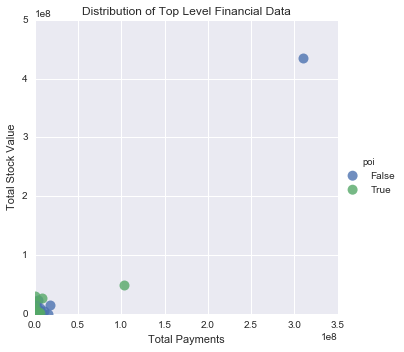

In [11]:
# Plot 'total_stock_value' vs. 'total_payments'

g = sns.lmplot('total_payments', 'total_stock_value', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Distribution of Top Level Financial Data')
plt.xlabel('Total Payments')
plt.ylabel('Total Stock Value')

g.set(ylim=(0, None))
g.set(xlim=(0, None))

A couple of points stick out as potential outliers. The first corresponds to a a 'total_payments' value in excess of $300 million, which seems outrageous even by Enron standards. It is also suspicious that this point doesn't correspond to a POI. Let's investigate further by getting the index name for the two points with very large total payment values:

In [12]:
df[df['total_payments']>1e8].index.tolist()

['LAY KENNETH L', 'TOTAL']

So the smaller outlier corresponds to a known person (Kenneth Lay, Chairman of Enron at the time of the company's collapse) and the larger outlier corresponds to 'Total'. Taking a closer look at the data file pdf, total is simply a sum of all the values for the various individuals in the dataset. It must be removed, as it poses a large risk of biasing the machine learning results, since it would look like an innocent person (i.e. a non POI) who received a massive payout.

Based on the fact that the 'Total' data row is included in the dataset, I manually inspected the PDF file for any other non-person data points. I noticed a row called 'The Travel Agency in the Park', with the following data for the various fields:

In [13]:
print df[df.index == 'THE TRAVEL AGENCY IN THE PARK'].values

[[0 0 0 0 0 0 0 0 0 0 0 0 362096 False 0 0 0 0 0 362096 0]]


According to the notes accompanying the PDF, The Travel Agency in the Park was a company controlled by Mr. Lay's sister, and they received an 'other' payment of $362,096. Given that this company is not really an Enron insider, I will drop it from the dataset, along with the 'Total' row, and replot the data:

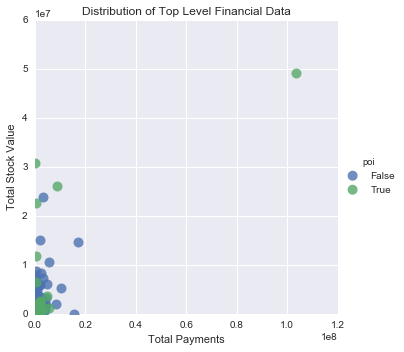

In [14]:
# Remove outliers and replot

df = df.drop(['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'])

g = sns.lmplot('total_payments', 'total_stock_value', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Distribution of Top Level Financial Data')
plt.xlabel('Total Payments')
plt.ylabel('Total Stock Value')

g.set(xlim=(0, None))
g.set(ylim=(0, None))

Based on the earlier analysis, I know that the 'outlier' now (with the total payment of approx. $100 million) is Kenneth Lay. Since he is a strong candidate as a POI, I definitely don't want to remove him from the dataset. However, I would like to view the data without his point distorting the graph, so I will regraph on a smaller axis to get a better view of the other points:

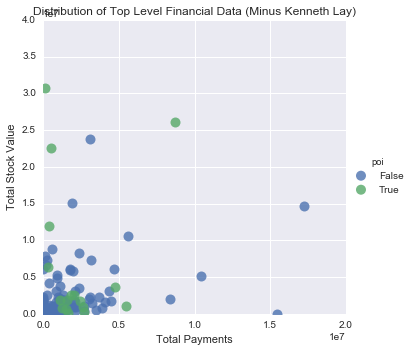

In [15]:
# Replot the data on a smaller scale, so as to focus on non Kenneth Lay individuals

g = sns.lmplot('total_payments', 'total_stock_value', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Distribution of Top Level Financial Data (Minus Kenneth Lay)')
plt.xlabel('Total Payments')
plt.ylabel('Total Stock Value')

g.set(ylim=(0, 0.4e8))
g.set(xlim=(0, 0.2e8))

There are no longer any obvious outliers. Next, I would like to conduct a 'sanity' check on the data. According to the PDF provided with the project, the 'total_payments' field should be equal to the sum of nine different fields and the 'total_stock_value' field should be equal to the sum of three other fields. I will now confirm that this holds true in the dataset.

In [16]:
# Create two new variables, TP_test and TSV_test, for checking whether the
# total_payments and total_stock_value fields respectively have been
# transcribed to the data file correctly. The full feature list
# is provided below for ease of copying / pasting

'''
Full Feature list:

features_list = ['poi','salary', 'deferral_payments', 'total_payments', 
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 
'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 
'long_term_incentive', 'restricted_stock', 'director_fees','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi']
'''

df['TP_test'] = df['total_payments']-(
    df['salary']+df['bonus']+df['long_term_incentive']+df['deferred_income']+
 df['deferral_payments']+df['loan_advances']+df['other']+df['expenses']+df['director_fees'])

df['TSV_test'] = df['total_stock_value']-(
    df['exercised_stock_options']+df['restricted_stock']+df['restricted_stock_deferred'])


print "Value count for 'total_payment' test failing:"
print df['TP_test'][df['TP_test']!=0].value_counts()

print "Value count for 'total_stock_value' test failing:"
print df['TSV_test'][df['TSV_test']!=0].value_counts()

Value count for 'total_payment' test failing:
201715      1
15180562    1
Name: TP_test, dtype: int64
Value count for 'total_stock_value' test failing:
-91471       1
-15456290    1
Name: TSV_test, dtype: int64


Based on the data above, it appears there are two instances where both the 'total_stock_value' and the 'total_payment' data is erroneous in some way, with one instance of each being of a very large magnitude (-$15MM). Let's now take a closer look at the specific rows generating the problems.

In [17]:
# print the names of individuals with extremely problematic data

print df[df['TP_test']>1e6].index.tolist()
print df[df['TSV_test']<-1e6].index.tolist()

['BHATNAGAR SANJAY']
['BHATNAGAR SANJAY']


The hugely erroneous point in both cases is for Sanjay Bhatnagar. Let's take a closer look at this person's specific data:

In [18]:
df[df.index == 'BHATNAGAR SANJAY'].drop(['poi','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'],axis=1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,TP_test,TSV_test
BHATNAGAR SANJAY,0,0,0,137864,2604490,0,0,0,137864,-2604490,15456290,0,15456290,0,15180562,-15456290


The raw data for Bhatnagar looks corrupted. The numerical values are correct, but they have been assigned to the wrong columns. For example, the Enron61702insiderpay.pdf file shows this person with $137,864 in 'expenses' whereas the data file has this value assigned to 'director_fees'. I will rebuild this row now, based on the PDF file. 

In [19]:
# Manually correct erroneous data for Sanjay Bhatnagar

df.loc['BHATNAGAR SANJAY','director_fees'] = 0
df.loc['BHATNAGAR SANJAY','exercised_stock_options'] = 15456290
df.loc['BHATNAGAR SANJAY','expenses'] = 137864
df.loc['BHATNAGAR SANJAY','other'] = 0
df.loc['BHATNAGAR SANJAY','restricted_stock'] = 2604490
df.loc['BHATNAGAR SANJAY','restricted_stock_deferred'] = -2604490
df.loc['BHATNAGAR SANJAY','total_payments'] = 137864
df.loc['BHATNAGAR SANJAY','total_stock_value'] = 15456290

# Run the TP_test and TSV_test calculations again

df['TP_test'] = df['total_payments']-(df['salary']+df['bonus']+df['long_term_incentive']+df['deferred_income']+
df['deferral_payments']+df['loan_advances']+df['other']+df['expenses']+df['director_fees'])

df['TSV_test'] = df['total_stock_value']-(df['exercised_stock_options']+df['restricted_stock']+
                                          df['restricted_stock_deferred'])
    
# Confirm that Sanjay Bhatnagar's data looks correct now
                                 
df[df.index == 'BHATNAGAR SANJAY'].drop(['poi','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'],axis=1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,TP_test,TSV_test
BHATNAGAR SANJAY,0,0,0,0,15456290,137864,0,0,0,2604490,-2604490,0,137864,15456290,0,0


Bhatnagar's data now passes both tests. I'll now move on to the other points that failed the test.

In [20]:
# Print the updated TP_test and TSV_test results

print "Value count for 'total_payment' test failing:"
print df['TP_test'][df['TP_test']!=0].value_counts()

print "Value count for 'total_stock_value' test failing:"
print df['TSV_test'][df['TSV_test']!=0].value_counts()

Value count for 'total_payment' test failing:
201715    1
Name: TP_test, dtype: int64
Value count for 'total_stock_value' test failing:
-91471    1
Name: TSV_test, dtype: int64


In [21]:
print df[df['TP_test']>2e5].index.tolist()
print df[df['TSV_test']<-9e4].index.tolist()

['BELFER ROBERT']
['BELFER ROBERT']


The data for Robert Belfer looks suspect. Lets take a closer look at the specifics.

In [22]:
df[df.index == 'BELFER ROBERT'].drop(['poi','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'],axis=1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,TP_test,TSV_test
BELFER ROBERT,0,-102500,0,3285,3285,0,0,0,0,0,44093,0,102500,-44093,201715,-91471


As with the previous person, the data for Belfer looks corrupted and will be manually corrected to match the PDF data.

In [23]:
# Manually correct erroneous data for Robert Belfer

df.loc['BELFER ROBERT','deferral_payments'] = 0
df.loc['BELFER ROBERT','deferred_income'] = -102500
df.loc['BELFER ROBERT','director_fees'] = 102500
df.loc['BELFER ROBERT','exercised_stock_options'] = 0
df.loc['BELFER ROBERT','expenses'] = 3285
df.loc['BELFER ROBERT','restricted_stock'] = 44093
df.loc['BELFER ROBERT','restricted_stock_deferred'] = -44093
df.loc['BELFER ROBERT','total_payments'] = 3285
df.loc['BELFER ROBERT','total_stock_value'] = 0

# Run the TP_test and TSV_test calculations again

df['TP_test'] = df['total_payments']-(df['salary']+df['bonus']+df['long_term_incentive']+df['deferred_income']+
df['deferral_payments']+df['loan_advances']+df['other']+df['expenses']+df['director_fees'])

df['TSV_test'] = df['total_stock_value']-(df['exercised_stock_options']+df['restricted_stock']+
                                          df['restricted_stock_deferred'])
    
# Confirm that Robert Belfer's data looks correct now
    
df[df.index == 'BELFER ROBERT'].drop(['poi','to_messages', 
'email_address', 'from_poi_to_this_person', 'from_messages', 
'from_this_person_to_poi', 'shared_receipt_with_poi'],axis=1)

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,TP_test,TSV_test
BELFER ROBERT,0,0,-102500,102500,0,3285,0,0,0,44093,-44093,0,3285,0,0,0


In [24]:
# Print the updated TP_test and TSV_test results

print "Value count for 'total_payment' test failing:"
print df['TP_test'][df['TP_test']!=0].value_counts()

print "Value count for 'total_stock_value' test failing:"
print df['TSV_test'][df['TSV_test']!=0].value_counts()

Value count for 'total_payment' test failing:
Series([], Name: TP_test, dtype: int64)
Value count for 'total_stock_value' test failing:
Series([], Name: TSV_test, dtype: int64)


All data points now pass the 'Total Payments' and 'Total Stock Value' tests. This concludes the outlier analysis portion.

### New Features

In this section, I will consider several new features that I believe will be of value in predicting POIs. The first set of two new features relates to financial parameters:

* total_payments / total_stock_value (label as TP_TSV_ratio): As discussed earlier, these two features encompass all the financial data. Taking the ratio provides a measurement of how much of an individual's compensation was paid in non-stock vs. stock payments, which could impact their behavior as it relates to short-term vs. long-term behavior.


* (deferred_income + restricted_stock_deferred) / (total_payments + total_stock_value) (label as deferred_total_ratio): This feature will measure how much of an individual's compensation was electively deferred, relative to total compensation. If an individual chose to defer a large portion of their compensation, they might be more interested in the long-term performance of the company.

The second set of two new features relates to email habits:

* (from_this_person_to_poi / from_messages) (label as to_poi_ratio): measures the proportion of a person's sent email messages that went to POIs. It is possible that POIs communicated more frequently with each other. 


* (from_poi_to_this_person / to_messages) (label as from_poi_ratio): measures the proportion of a person's received email messages that came from POIs. It is possible that POIs communicated more frequently with each other. 

Before proceeding, I will replace the zero values in the dataframe with 'np.nan'. Zero values were useful for the various outlier checks, but now that I am moving forward with the POI identifier, I want to explicitly distinguish between missing values (i.e. NaN in the original data dictionary) and those values that are very close to zero (e.g. low salary, low bonus etc.). Further, since the synthetic features involve dividing, I want to avoid scenarios where I am dividing by zero.

In [26]:
# Replace zeroes with NaN

df.replace(0, np.nan, inplace = True)

In [27]:
# Encode the new features

df['TP_TSV_ratio'] = df['total_payments'] / df['total_stock_value']

df['deferred_total_ratio'] = df['deferred_income']+df['restricted_stock_deferred']/(
    df['total_payments']+df['total_stock_value'])

df['to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']

df['from_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']

In [28]:
# Get statistics

print df['TP_TSV_ratio'].describe()
print df['deferred_total_ratio'].describe()
print df['to_poi_ratio'].describe()
print df['from_poi_ratio'].describe()

count    107.000000
mean       2.171968
std        5.095500
min        0.000214
25%        0.298346
50%        0.872703
75%        2.122813
max       48.152302
Name: TP_TSV_ratio, dtype: float64
count    9.000000e+00
mean    -7.266510e+05
std      9.966219e+05
min     -3.081055e+06
25%     -9.344841e+05
50%     -2.016411e+05
75%     -3.333316e+04
max     -5.104091e+03
Name: deferred_total_ratio, dtype: float64
count    66.000000
mean      0.239830
std       0.210767
min       0.009302
25%       0.054855
50%       0.218968
75%       0.341400
max       1.000000
Name: to_poi_ratio, dtype: float64
count    74.000000
mean      0.044119
std       0.040481
min       0.001068
25%       0.016370
50%       0.029580
75%       0.059118
max       0.217341
Name: from_poi_ratio, dtype: float64


The new features could not be calculated for all 144 people, owing to missing data. This problem is particularly stark for the 'deferred_total_ratio', where only 9 people had sufficient data to calculate a value (see above statistics). 

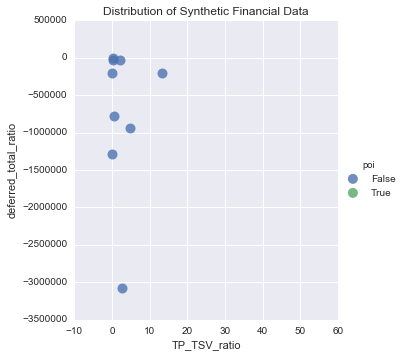

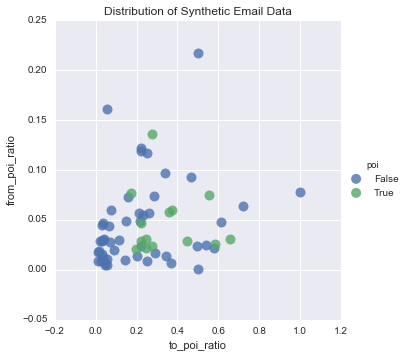

In [29]:
# Examine the new features in 2D space

# Financial Features

g = sns.lmplot('TP_TSV_ratio', 'deferred_total_ratio', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Distribution of Synthetic Financial Data')
plt.xlabel('TP_TSV_ratio')
plt.ylabel('deferred_total_ratio')

#g.set(ylim=(0, 1))
#g.set(xlim=(0, 1))

# Email Features

g = sns.lmplot('to_poi_ratio', 'from_poi_ratio', 
           data=df, 
           fit_reg=False, 
           hue='poi',
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Distribution of Synthetic Email Data')
plt.xlabel('to_poi_ratio')
plt.ylabel('from_poi_ratio')

#g.set(ylim=(0, 1))
#g.set(xlim=(0, 1))

It appears that all nine points with calculable 'deferred_total_ratio' values are non-POIs. This might be a useful feature for detecting a small set of true negatives. In regards to email habits, the POIs appear to have all clustered within a 'from_poi_ratio' range from 0.00 to 0.15 and a 'to_poi_ratio' band from 0.20 to 0.60. This clustering might mean that this feature will prove useful for identifying POIs.

### Dataframe to Dictionary

I am going to drop the 'TP_test' and 'TSV_test' features from the dataframe, as they have served their outlier detection purposes. After that, I will convert the dataframe back to a dictionary format, for use in the machine learning steps.

In [30]:
# drop TP_test and TSV_test

df = df.drop(['TP_test', 'TSV_test'],axis=1)

In [31]:
# Feature magnitudes, for informational purposes

df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,TP_TSV_ratio,deferred_total_ratio,to_poi_ratio,from_poi_ratio
count,8.100000e+01,3.700000e+01,4.900000e+01,15.000000,1.000000e+02,96.000000,86.000000,74.000000,66.000000,3.000000e+00,...,1.700000e+01,9.400000e+01,86.000000,86.000000,1.230000e+02,1.250000e+02,107.000000,9.000000e+00,66.000000,74.000000
mean,1.201773e+06,8.671188e+05,-5.712835e+05,93234.466667,3.117640e+06,54533.312500,608.790698,75.418919,53.727273,2.797500e+07,...,-4.456934e+05,2.840875e+05,1176.465116,2073.860465,2.516459e+06,3.476076e+06,2.171968,-7.266510e+05,0.239830,0.044119
std,1.441679e+06,1.297344e+06,9.347149e+05,33320.075521,5.657924e+06,46712.751852,1841.033949,89.467681,111.420002,4.638256e+07,...,6.934388e+05,1.771311e+05,1178.317641,2582.700981,9.455875e+06,6.614499e+06,5.095500,9.966219e+05,0.210767,0.040481
min,7.000000e+04,7.961000e+03,-3.504386e+06,17500.000000,9.803000e+03,148.000000,12.000000,1.000000,1.000000,4.000000e+05,...,-2.604490e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,2.879800e+04,0.000214,-3.081055e+06,0.009302,0.001068
25%,4.250000e+05,8.543000e+04,-5.833250e+05,100017.000000,5.701288e+05,22140.500000,22.750000,20.500000,6.000000,1.200000e+06,...,-4.095540e+05,2.118020e+05,249.750000,541.250000,3.773875e+05,4.956330e+05,0.298346,-9.344841e+05,0.054855,0.016370
50%,7.500000e+05,2.274490e+05,-1.440620e+05,103750.000000,1.310814e+06,46547.500000,41.000000,40.500000,15.000000,2.000000e+06,...,-1.536860e+05,2.587410e+05,740.500000,1211.000000,1.099100e+06,1.110705e+06,0.872703,-2.016411e+05,0.218968,0.029580
75%,1.200000e+06,8.753070e+05,-3.834600e+04,110895.000000,2.544450e+06,79252.250000,145.500000,93.500000,37.750000,4.176250e+07,...,-8.278200e+04,3.086065e+05,1888.250000,2634.750000,2.064694e+06,3.064208e+06,2.122813,-3.333316e+04,0.341400,0.059118
max,8.000000e+06,6.426990e+06,-8.330000e+02,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,8.152500e+07,...,-3.246000e+04,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07,48.152302,-5.104091e+03,1.000000,0.217341


In [32]:
# Replace np.nan with NaN (for compatibility with feature_format.py)

df.replace(np.nan, 'NaN', inplace = True)

# create a dictionary from the dataframe
df_dict = df.to_dict('index')


In [33]:
# Confirm that updated dictionary contains new features

print df_dict["SKILLING JEFFREY K"]

{'to_messages': 3627.0, 'deferral_payments': 'NaN', 'deferred_total_ratio': 'NaN', 'expenses': 29336.0, 'poi': True, 'long_term_incentive': 1920000.0, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88.0, 'deferred_income': 'NaN', 'TP_TSV_ratio': 0.3327517874831875, 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 2042.0, 'loan_advances': 'NaN', 'from_messages': 108.0, 'other': 22122.0, 'to_poi_ratio': 0.2777777777777778, 'director_fees': 'NaN', 'bonus': 5600000.0, 'total_stock_value': 26093672.0, 'from_this_person_to_poi': 30.0, 'from_poi_ratio': 0.0242624758753791, 'restricted_stock': 6843672.0, 'salary': 1111258.0, 'total_payments': 8682716.0, 'exercised_stock_options': 19250000.0}


### Feature Selection

The features_list contains the features that will be fed to the machine learning algorithm. This list allows me to manually remove features. Since I will be building automatic feature selection into the machine learning optimization process, there is little need for any manual adjustment here. The lone exception was the removal of 'email_address' from the full feature_list, since for the direction I took (which was not to analyse email text), the 'email_address' serves no purpose.

In [35]:
# Store modified dictionary to my_dataset for easy export below.

my_dataset = df_dict

# Full features list, for informational / copying purposes

'''
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 
'total_stock_value', 'expenses', 'exercised_stock_options', 'other','email_address',
'long_term_incentive', 'restricted_stock', 'director_fees','to_messages',
'from_poi_to_this_person', 'from_messages','from_this_person_to_poi', 
'shared_receipt_with_poi','to_poi_ratio','from_poi_ratio','TP_TSV_ratio','deferred_total_ratio']
'''

# Used features lists
# CRITICAL that 'poi' is listed 1st in 'features_list' (see feature_format.py)

# features_list lets me test the results including the four new features
# excluded features: email_address

features_list = ['poi','salary', 'deferral_payments', 'total_payments', 
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 
'total_stock_value', 'expenses', 'exercised_stock_options', 'other',
'long_term_incentive', 'restricted_stock', 'director_fees','to_messages',
'from_poi_to_this_person', 'from_messages','from_this_person_to_poi', 
'shared_receipt_with_poi','to_poi_ratio','from_poi_ratio','TP_TSV_ratio',
'deferred_total_ratio']

# features_list_minus_new lets me test the results if the new features are excluded
# excluded features: email_address,'to_poi_ratio','from_poi_ratio','TP_TSV_ratio','deferred_total_ratio'

features_list_minus_new = ['poi','salary', 'deferral_payments', 'total_payments', 
'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 
'total_stock_value', 'expenses', 'exercised_stock_options', 'other',
'long_term_incentive', 'restricted_stock', 'director_fees','to_messages',
'from_poi_to_this_person', 'from_messages','from_this_person_to_poi', 
'shared_receipt_with_poi']

# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

# Uncomment the line below to test performance minus new features:
#data = featureFormat(my_dataset, features_list_minus_new, sort_keys = True)

labels, features = targetFeatureSplit(data)

# Count number of people in data set
# 'targetFeatureSplit' nets out those dropped due to all zeroes

print "Net data set size (# people):",len(labels)

Net data set size (# people): 143


The process of getting the labels and features into a suitable form includes the option to drop points with all zero (or all NaN) values. I have used this option, and the above row shows that doing so resulted in one person being dropped (144 became 143).

### Machine Learning Algorithms - First Pass with Default Settings

Now that the data has been explored, cleaned and put into a suitable form for the sklearn algorithms, it is time to build a POI identifier. The first step will be to test a variety of classifiers to get a feel for whether any stand out as candidates worth further investigation. After this step, the final classifier(s) will be optimized for the task at hand.

For both of these steps, I will be measuring the time it takes to train/test/fit/predict a given algorithm, since the development and run time is one of the factors that should be taken into account when choosing a model.

In [36]:
# Import the desired classifiers, splitters, metrics etc.

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

from time import time

# All classifiers are named clf for compatibility with tester.py
# Comment out ('#') all classifiers other than the desired one

#clf = GaussianNB()
clf = DecisionTreeClassifier(random_state=42)
#clf = SVC(random_state=42)
#clf = KNeighborsClassifier()
#clf = RandomForestClassifier(random_state=42)
#clf = GradientBoostingClassifier(random_state=42)
#clf = AdaBoostClassifier(random_state=42)

# Split data into training and testing sets, using 30% split

t0 = time()

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
clf.fit(features_train,labels_train)
labels_pred = clf.predict(features_test)

print classification_report(labels_test, labels_pred)

print "total train/test/prediction time:", round(time()-t0, 3), "s"

             precision    recall  f1-score   support

        0.0       0.92      0.89      0.91        38
        1.0       0.33      0.40      0.36         5

avg / total       0.85      0.84      0.84        43

total train/test/prediction time: 0.003 s


#### First Pass Results:

The project requires that the final algorithm exceeds 0.3 in both precision and recall, so these two metrics are a critical part of the model evaluation process. The following results were achieved for each of the 7 algorithms tested, under two scenarios. In the first scenario, the four new features were excluded. In the second scenario, they were included: 

| Algorithm | New Features Included? | Precision | Recall | F1 Score | Runtime (ms) |
|------|------|
| GaussianNB (GNB) | No | 0.50 | 0.40 | 0.44 | 3 | 
| DecisionTreeClassifier (DTC) | No | 0.00 | 0.00 | 0.00 | 3 |
| SupportVectorClassifier (SVC) | No | 0.00 | 0.00 | 0.00 | 3 |
| KNeighborsClassifier (KNN) | No | 0.00 | 0.00 | 0.00 | 4 |
| RandomForestClassifier (RFC) | No | 0.50 | 0.20 | 0.29 | 44 |
| GradientBoostingClassifier (GBC) | No | 0.25 | 0.20 | 0.22 | 67 |
| AdaBoostClassifier (ABC) | No | 0.17 | 0.20 | 0.18 | 130 |
| GaussianNB (GNB) | Yes | 0.14 | 0.80 | 0.24 | 3 | 
| DecisionTreeClassifier (DTC) | Yes | 0.33 | 0.40 | 0.36 | 3 |
| SupportVectorClassifier (SVC) | Yes | 0.00 | 0.00 | 0.00 | 3 |
| KNeighborsClassifier (KNN) | Yes | 0.00 | 0.00 | 0.00 | 4 |
| RandomForestClassifier (RFC) | Yes | 1.00 | 0.20 | 0.33 | 44 |
| GradientBoostingClassifier (GBC) | Yes | 0.25 | 0.20 | 0.22 | 74 |
| AdaBoostClassifier (ABC) | Yes | 0.20 | 0.20 | 0.20 | 135 |

The following key observations were made when comparing the effect of excluding or including the new features:

* Including the new features __**improved**__ the first pass results for the following algorithms:
    * DTC
    * RFC
    * ABC
    
* Including the new features had __**no impact**__ on the first pass results for the following algorithms:
    * SVC
    * KNN
    * GBC
    
* Including the new features __**worsened**__ the first pass results for the following algorithms:
    * GNB
    
So for the most part, the new features either improve or have no impact on the first pass results for the algorithms of interest. In addition, the one algorithm that was worsened by including the new features (GNB) has very few tuning parameters and therefore is not nearly as interesting to me for the validation, tuning and optimization portion of the project. Based on these results, I will proceed with a features_list that includes the four new features.

The following key observations were made from these initial results, under the scenario where the new features were included:

* DTC was the only algorithm to achieve the desired 0.3 threshold on precision and recall with this basic model. It also has a very short runtime compared to other promising candidates and hence will definitely proceed to the next stage.


* SVC and KNN failed to correctly identify any POIs, with precision and recall values of 0.00. This does not mean that they might not work well if optimized later, but since I plan on moving forward with a small subset of algorithms (possibly only 1), they will not be selected, given other algorithms showed promise.


* The runtimes on RFC, GBC and ABC were orders of magnitude longer than the more simple algorithms. This is not a problem at this stage, but could become an issue as model complexity expands during the cross validation stage of the project.

In [37]:
# Dump classifer and data for checking via tester.py

dump_classifier_and_data(clf, my_dataset, features_list)

After running the DTC classifier along with the selected features and dataset (clf, features_list, my_dataset), the following results were achieved via tester.py:

* Precision = 0.29874
* Recall = 0.29650

Therefore, a standard DTC model is close to achieving the project requirements. Based on these results, I will proceed with the optimization of the DTC model, since the advantage in runtime over RFC, GBC and ABC is a compelling advantage for speedily completing the development work. If I am unable to achieve satisfactory results with DTC, then I will consider the other models for further development.

### Machine Learning Algorithm - Optimization via Feature Selection and Cross Validation

The final step in the project is to optimize the classifier for improved precision  and recall results. Since the F1 score combines precision and recall, it was used as the optimization target, with the expectation that higher F1s would correspond to better precision / recall combinations. In order to efficiently optimize the classifier, Pipelines (see http://scikit-learn.org/stable/modules/pipeline.html) was used. Doing so allows feature selection, principal component analysis (PCA), model fitting and cross validation to be done in union.

The code below was built to allow lots of flexibility when testing and optimizing the classifier. Code that is commented out was used (and should be kept as part of the project record) but ultimately not included in the submitted algorithm. Please refer to the project report for details on the sequence of steps taken to arrive at the submitted model.

In [38]:
# This code block was used to optimize the model
# Various pipe components were commented / uncommented to test their effects
# The process and interim results are discussed in the accompanying report

# Import the necessary libaries

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

t0 = time()

# Build estimator from PCA and Univariate selection:

#combined_features = FeatureUnion([('pca', PCA()), ('select', SelectKBest())])

# Use combined features to transform dataset:

#X_features = combined_features.fit(features,labels).transform(features)

# Piping: combine scaling, feature selection, PCA and classification
# into a single pipeline

algo = DecisionTreeClassifier(random_state=42)

pipe = Pipeline([
#        ('scaler',MinMaxScaler()),
        ('select',SelectKBest()),
#                 ('reduce_dim', PCA()),
#        ('features',combined_features),
                 ('algo',algo)
    ])

# Cross Validation - choose parameters that maximize the F1 score

# Parameter grid

para = {
    'select__k':[23],
#    'select__k':np.arange(22,24),
#    'reduce_dim__n_components':np.arange(1,15),
#    'features__pca__n_components':[1, 2, 3],
#    'features__select__k':np.arange(1,24),
    'algo__criterion': ["gini"],
#    'algo__criterion': ["gini","entropy"],
    'algo__min_samples_split': [10],
#    'algo__min_samples_split': [2, 10, 20],
#    'algo__min_samples_split': np.arange(5,8),
    'algo__max_depth': [4],
#    'algo__max_depth': [None, 2, 5, 10],
#    'algo__max_depth': np.arange(4, 7),
    'algo__min_samples_leaf': [1],
#    'algo__min_samples_leaf': [1, 5, 10],
#    'algo__min_samples_leaf': np.arange(1,3),
    'algo__class_weight':["balanced"],
#    'algo__class_weight':["balanced",None],
    'algo__max_leaf_nodes':[8],
#    'algo__max_leaf_nodes':np.arange(7,11),
    'algo__splitter': ["random"]
#    'algo__splitter': ["best","random"]
       }

# Because of the small size of the dataset, use stratified shuffle split cross validation
# I found that 50 splits provided scores that closely matched the tester.py results and also
# kept runtimes to relatively reasonable durations

sss = StratifiedShuffleSplit(labels, 50, random_state = 42)
cv_clf = GridSearchCV(pipe,param_grid=para, cv = sss, scoring='f1')
cv_clf.fit(features,labels)
clf = cv_clf.best_estimator_

print "model build and validation time:", round(time()-t0, 3), "s"
print '\n'
print "Best F1 score: %0.3f" % cv_clf.best_score_
print '\n'
print "Best Parameters:"
print '\n'
print cv_clf.best_params_
print '\n'

model build and validation time: 0.537 s


Best F1 score: 0.492


Best Parameters:


{'algo__class_weight': 'balanced', 'algo__min_samples_split': 10, 'select__k': 23, 'algo__splitter': 'random', 'algo__max_depth': 4, 'algo__criterion': 'gini', 'algo__min_samples_leaf': 1, 'algo__max_leaf_nodes': 8}




In [39]:
# Dump classifer and data for checking the current model via tester.py

dump_classifier_and_data(clf, my_dataset, features_list)

In [40]:
# Extract SelectKBest Features and Scores

K_scores = clf.named_steps['select'].scores_
feature_used = clf.named_steps['select'].get_support()

Net_K_scores = K_scores * feature_used

scores=[]
features_k=[]
i = 0
while i < len(K_scores):
    if Net_K_scores[i] > 0:
        scores.append(K_scores[i])
        features_k.append(features_list[i+1]) #+1 to account for 'poi' as 1st on 'features_list'
        i += 1
    else:
        i += 1
        
KB_scores = np.column_stack((features_k,scores))

T1 = KB_scores[0:,1]

T2=[]
for string in T1:
    num = float(string)
    T2.append(num)
    
KBest_scores_DF = pd.DataFrame(data = T2, index = KB_scores[0:,0])
KBest_scores_DF.columns = ['KBest_Score']
print KBest_scores_DF.sort_values('KBest_Score',ascending=False)

                           KBest_Score
total_stock_value            22.510549
exercised_stock_options      22.348975
bonus                        20.792252
salary                       18.289684
to_poi_ratio                 16.409713
deferred_income              11.424891
long_term_incentive           9.922186
total_payments                9.283874
restricted_stock              8.825442
shared_receipt_with_poi       8.589421
loan_advances                 7.184056
expenses                      5.418900
from_poi_to_this_person       5.243450
other                         4.202436
from_poi_ratio                3.128092
from_this_person_to_poi       2.382612
director_fees                 2.131484
to_messages                   1.646341
restricted_stock_deferred     0.768146
TP_TSV_ratio                  0.605429
deferred_total_ratio          0.491475
deferral_payments             0.228860
from_messages                 0.169701


In [41]:
# Extract Decision Tree Feature Importances

importances = clf.named_steps['algo'].feature_importances_

DT_scores = np.column_stack((KB_scores[0:,0],importances))

T3 = DT_scores[0:,1]

T4=[]
for string in T3:
    num = float(string)
    T4.append(num)
    
DT_scores_DF = pd.DataFrame(data = T4, index = DT_scores[0:,0])
DT_scores_DF.columns = ['Feature_Importance']
print DT_scores_DF.sort_values('Feature_Importance',ascending=False)

                           Feature_Importance
to_poi_ratio                         0.518960
restricted_stock                     0.174142
total_stock_value                    0.111818
TP_TSV_ratio                         0.101889
to_messages                          0.061206
restricted_stock_deferred            0.031985
salary                               0.000000
director_fees                        0.000000
from_poi_ratio                       0.000000
shared_receipt_with_poi              0.000000
from_this_person_to_poi              0.000000
from_messages                        0.000000
from_poi_to_this_person              0.000000
long_term_incentive                  0.000000
deferral_payments                    0.000000
other                                0.000000
exercised_stock_options              0.000000
expenses                             0.000000
deferred_income                      0.000000
bonus                                0.000000
loan_advances                     

### Final Model

Based on the optimization work outlined above, the following final model was generated:

In [42]:
# Final model
# Based on the optimization work discussed above,
# the following final model is submitted for evaluation
# All features (including 4 synthetic features) other than 'email_address' should be used
# Code block will dump classifer and data for checking via tester.py

clf = DecisionTreeClassifier(splitter="random",
                             max_depth=4,
                             min_samples_split=10,
                             max_leaf_nodes=8,
                             class_weight="balanced",
                             random_state=42)

clf.fit(features,labels)

dump_classifier_and_data(clf, my_dataset, features_list)

print "classifier and data have been generated for testing via tester.py"

classifier and data have been generated for testing via tester.py


### Conclusion

The work in this notebook provided the steps for generating an Enron POI machine learning classifer. The data was analysed and cleaned and new synthetic features were generated. The data was then formatted for machine learning algorithms. A variety of algorithms were tested and ultimately a decision tree classifier (DTC) was optimized using a variety of techniques, most notably univariate feature selection (via the SelectKBest model) and grid search cross validation. The final model achieved a precision of 0.35 and a recall of 0.81, which exceeded the project mandate to get at least 0.30 for each of these parameters. Further details can be found in the accompanying report.